In [1]:
from preprocessing import prepare_subject_sample
from preprocessing import get_predicted_bold_response, get_predicted_neural_activity, plot_voxel_timecourse
from nilearn.plotting import plot_design_matrix

In [2]:
subject = "127630"
task = "LANGUAGE"
acq = "RL"
smoothing = 10
TR = 0.72 

In [3]:
data, glm, mask = prepare_subject_sample(
    subject=subject, 
    task=task, 
    acquisition=acq, 
    smoothing=smoothing, 
    voxel_quantile=98, 
    label_extraction=get_predicted_neural_activity,
)

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task LANGUAGE
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_LANGUAGE_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_LANGUAGE_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_LANGUAGE_RL_event.csv
first GLM to select active voxel
computing f-map and selecting 98th voxel
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_LANGUAGE_RL_smooth-10mm_fmap.nii.gz
(1939, 316)


In [4]:
bold, block, conv = data

In [5]:
import numpy as np
import random

def normalize(X):
    epsilon = 1e-8
    return (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + epsilon)

In [6]:
bold_norm, block_norm, conv_norm = normalize(bold), normalize(block), normalize(conv)

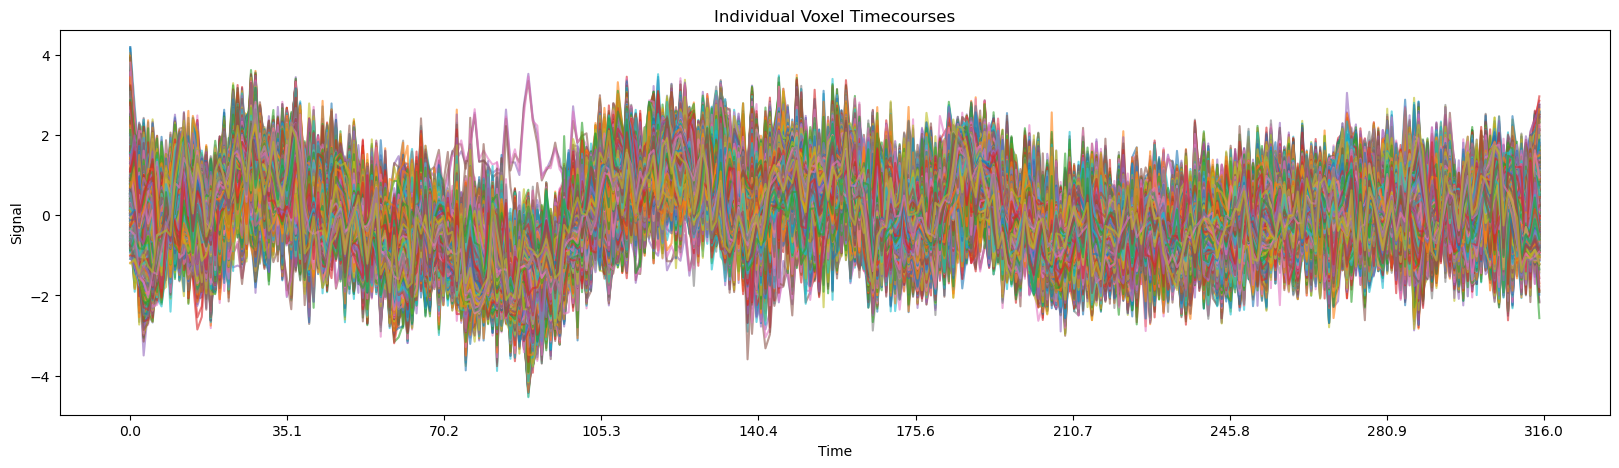

In [7]:
plot_voxel_timecourse(bold)

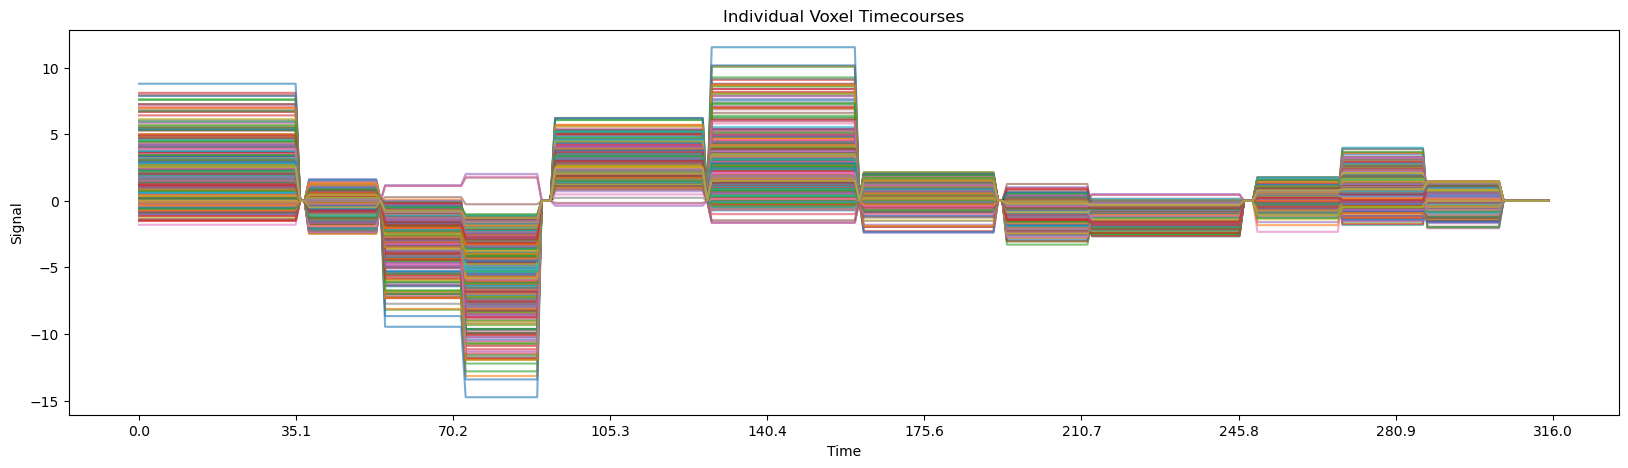

In [8]:
plot_voxel_timecourse(block)

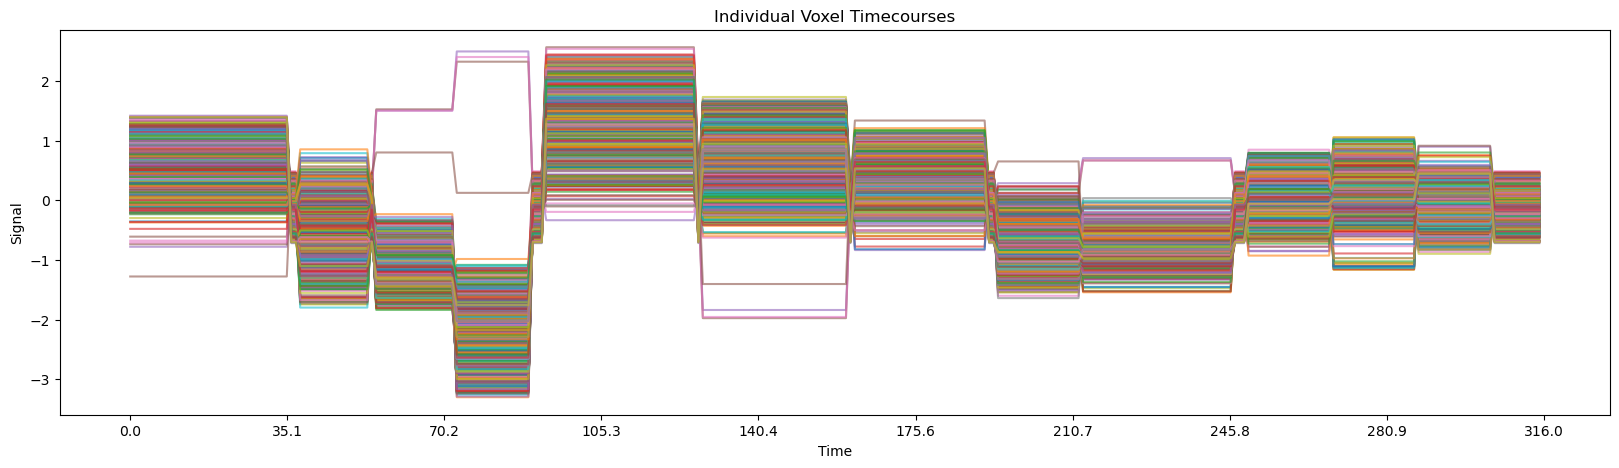

In [9]:
plot_voxel_timecourse(block_norm)

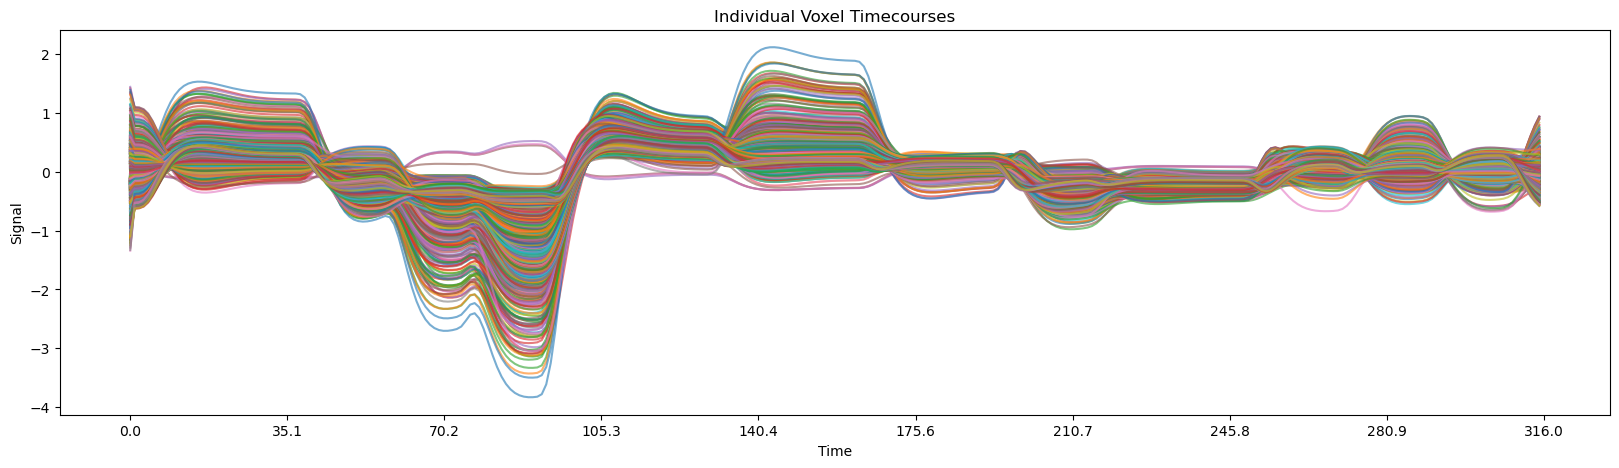

In [10]:
plot_voxel_timecourse(conv)

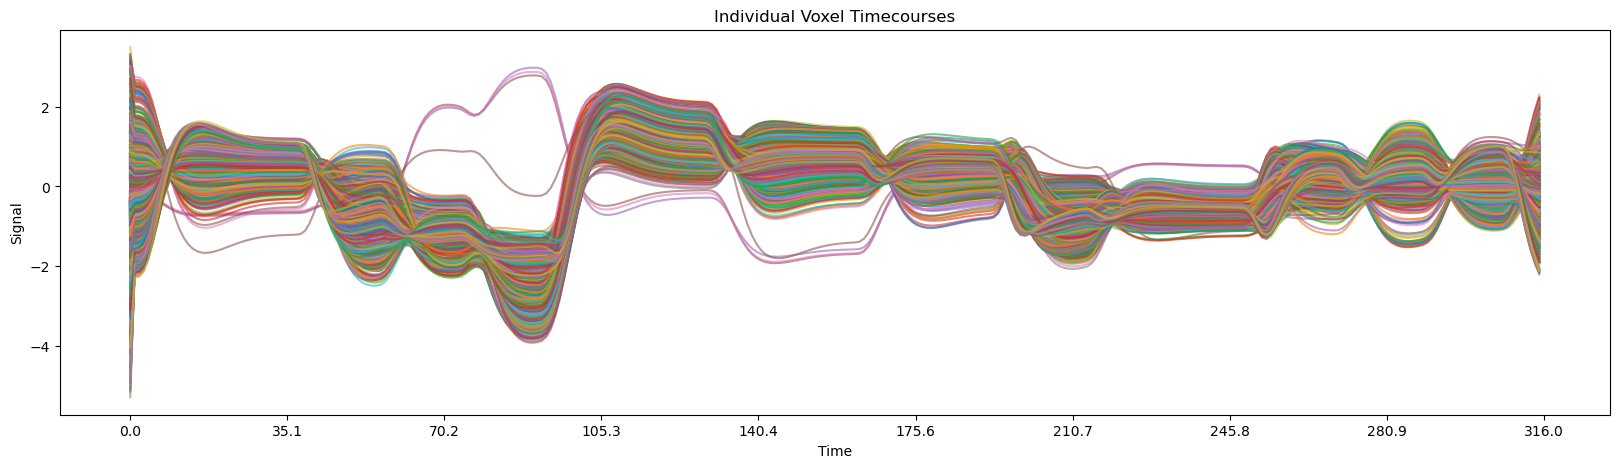

In [11]:
plot_voxel_timecourse(conv_norm)

In [35]:
from viz import plot_voxels

In [36]:
n_samples = 42

plot_voxels(bold_norm, block_norm, conv_norm, n_samples=n_samples, seed=54, print_x=True)

NameError: name 'bold_norm' is not defined

(1939, 316) (1939, 316) (1939, 316)


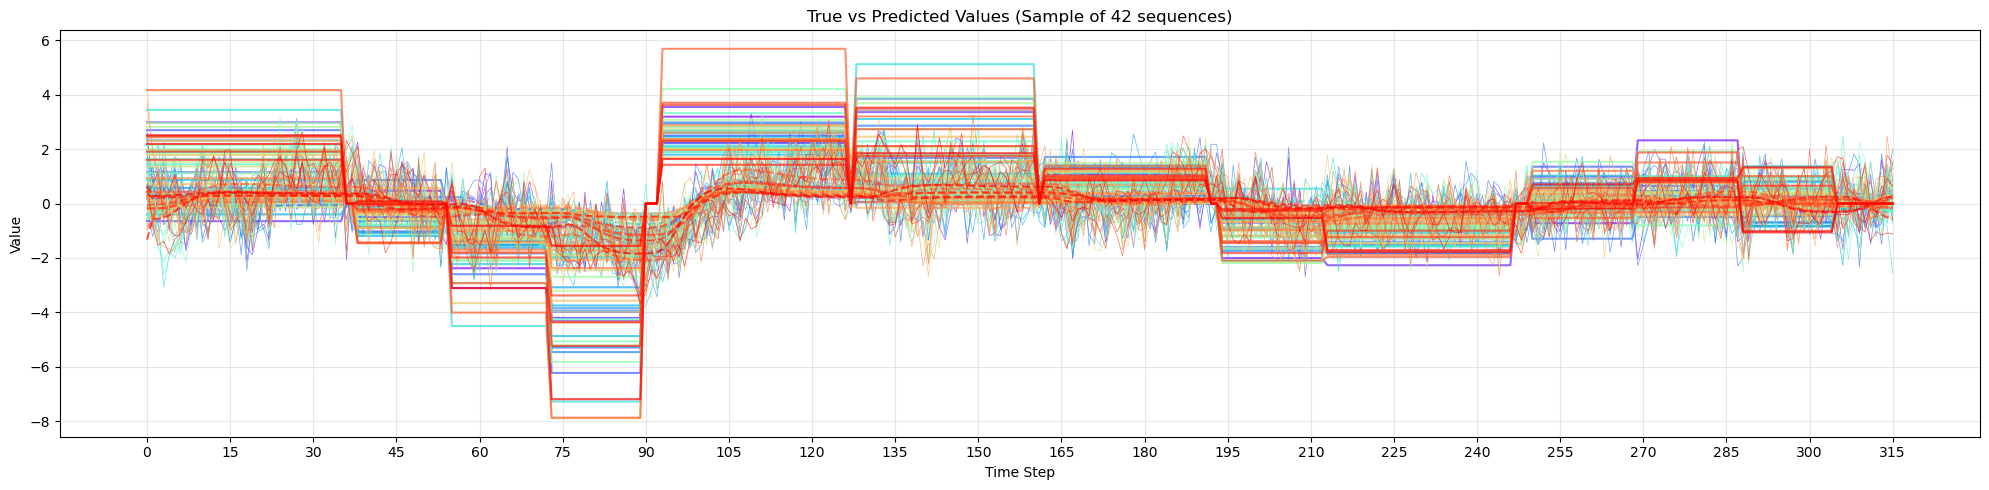

In [14]:
plot_voxels(bold_norm, block, conv, n_samples=n_samples, seed=54, print_x=True)

In [15]:
from preprocessing import merge_dataset
import xarray as xr

In [16]:
merged = merge_dataset([
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_LANGUAGE_1_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_EMOTION_1_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_WM_1_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_RELATIONAL_1_subjects_normed.nc"),
])

316 LANGUAGE
176 EMOTION
405 WM
232 RELATIONAL


In [6]:
merged.X.shape

(13573, 405)

(13573, 405) (13573, 405) (13573, 405)


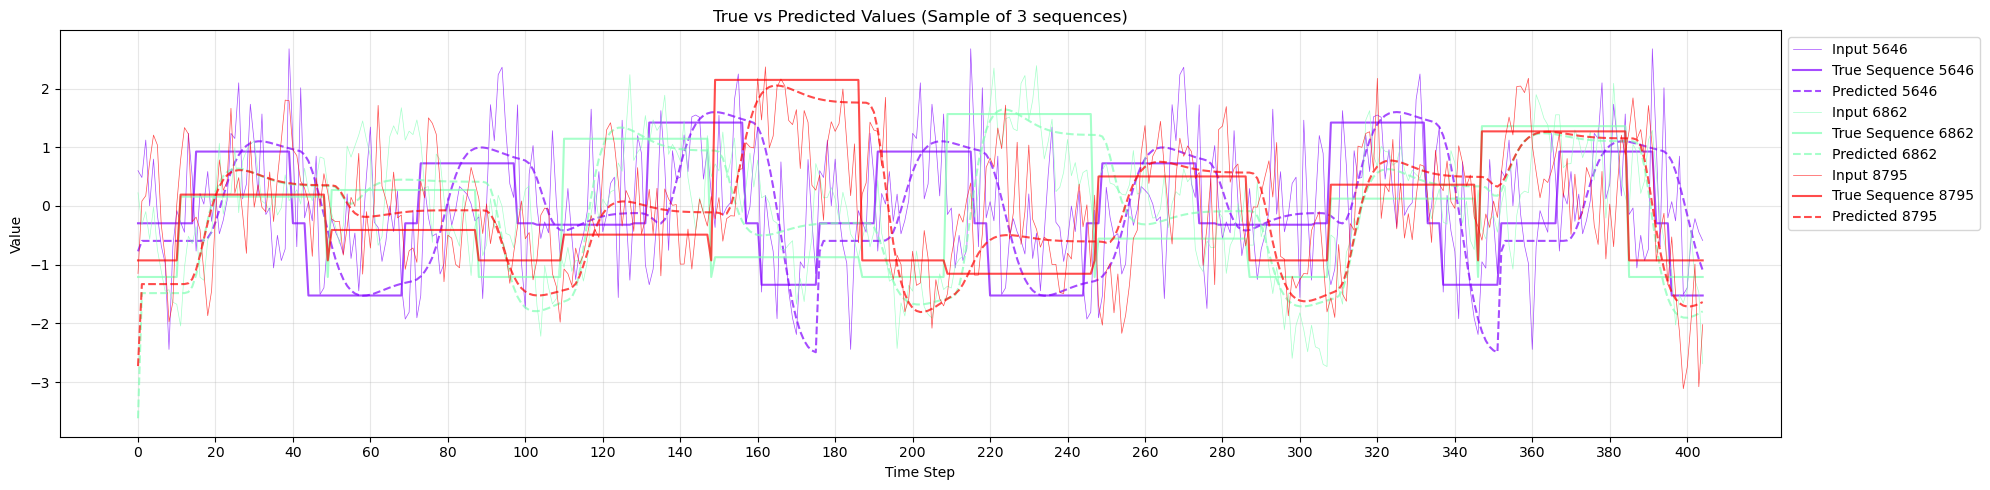

In [21]:
n_samples = 3

plot_voxels(merged.X, merged.Y, merged.Y_conv, n_samples=n_samples, seed=None, print_x=True)

In [28]:
def merge_dataset(datasets):
    max_len = max(ds.dims['time'] for ds in datasets)
    
    padded = []
    for ds in datasets:
        if ds.dims['time'] < max_len:
            pad_idx = np.arange(max_len - ds.dims['time']) % ds.dims['time']
            padded_data = {var: (ds[var].dims, 
                               np.concatenate([ds[var].values, ds[var].values[..., pad_idx]], axis=-1))
                          for var in ds.data_vars if 'time' in ds[var].dims}
            
            padded.append(xr.Dataset(
                padded_data,
                coords={'time': np.arange(max_len), **{c: ds[c] for c in ds.coords if c != 'time'}}
            ))
        else:
            padded.append(ds)

    return xr.concat(padded, dim='task')  # Changed from 'subject' to 'task'

In [29]:
merged = merge_dataset([
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_LANGUAGE_100_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_EMOTION_100_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_WM_100_subjects_normed.nc"),
])

In [30]:
selected_subjects = np.random.choice(merged.subject.values, size=15, replace=False)

In [31]:
selected_subjects

array(['147737_LR', '110411_RL', '198451_LR', '198451_RL', '103414_LR',
       '239944_RL', '239944_LR', '397760_RL', '196750_LR', '122620_RL',
       '114419_LR', '148840_RL', '103111_LR', '128632_RL', '128632_LR'],
      dtype=object)

In [21]:
merged

<xarray.Dataset>
Dimensions:     (time: 405, voxel_subj: 1193400)
Coordinates:
  * time        (time) int64 0 1 2 3 4 5 6 7 ... 397 398 399 400 401 402 403 404
    task        (voxel_subj) <U8 'LANGUAGE' 'LANGUAGE' 'LANGUAGE' ... 'WM' 'WM'
  * voxel_subj  (voxel_subj) object MultiIndex
  * subject     (voxel_subj) object '100307_RL' '100307_RL' ... '899885_LR'
  * voxel       (voxel_subj) int64 0 1 2 3 4 5 ... 1983 1984 1985 1986 1987 1988
Data variables:
    X           (voxel_subj, time) float64 1.075 -0.956 -2.125 ... nan nan nan
    Y           (voxel_subj, time) float64 -0.3979 -0.3979 -0.3979 ... nan nan
    Y_conv      (voxel_subj, time) float64 -2.729 -2.157 -2.146 ... nan nan nan

In [32]:
subset_dataset = merged.sel(subject=selected_subjects)

In [43]:
subset_dataset

<xarray.Dataset>
Dimensions:  (task: 3, subject: 15, voxel: 1989, time: 405)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 397 398 399 400 401 402 403 404
  * voxel    (voxel) int64 0 1 2 3 4 5 6 ... 1982 1983 1984 1985 1986 1987 1988
  * subject  (subject) object '147737_LR' '110411_RL' ... '128632_LR'
  * task     (task) <U8 'LANGUAGE' 'EMOTION' 'WM'
Data variables:
    X        (task, subject, voxel, time) float64 -0.06659 -1.684 ... nan nan
    Y        (task, subject, voxel, time) float64 -0.4637 -0.4637 ... nan nan
    Y_conv   (task, subject, voxel, time) float64 -0.7506 -0.4367 ... nan nan

In [45]:
combined = subset_dataset.stack(combined_subjects=('task', 'subject')).transpose('combined_subjects', 'voxel', 'time')

In [49]:
combined

<xarray.DataArray 'X' (combined_subjects: 45, voxel: 1989, time: 405)>
array([[[-6.65902860e-02, -1.68375116e+00, -9.38472582e-01, ...,
         -2.27995849e-01, -2.91763976e-01, -7.75673023e-01],
        [-2.84204020e-01, -2.06250489e+00, -1.26751435e+00, ...,
         -4.50066664e-01, -1.90007724e-01, -5.83772265e-01],
        [-2.64937448e-01, -1.68892199e+00, -1.05331485e+00, ...,
         -5.13389793e-01, -2.89150058e-01, -9.23588833e-01],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-1.23895775e+00, -2.84967515e+00, -2.44202241e+00, ...,
         -3.99568569e-02,  2.18990289e-01, -8.36581605e-01],
        [-1.18920965e+00, -2.96987267e+00, -2.65932772e+00, ...,
         -6.79648560e-02, -6.41700485e-03, -6.75800276e-01],
        [-1.08872759e+00, -2.97277892e+00, -2.66126445e+00, ...,
         -4.02724087e-02,  9.99528784e-02, -6.95078617e-01],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-1.21066620e+00, -1.83982566e+00, -2.47273415e+00, ...,
          4.96107323e-01,  3.16590351e-01, -3.22209763e-02],
        [-1.01734827e+00, -1.91257494e+00, -2.48283635e+00, ...,
         -2.01379128e-02,  2.91555730e-03, -1.80395653e-01],
        [-1.02569196e+00, -1.85863697e+00, -2.52506309e+00, ...,
          6.49100081e-02, -7.20808288e-02, -3.21208189e-01],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * time               (time) int64 0 1 2 3 4 5 6 ... 399 400 401 402 403 404
  * voxel              (voxel) int64 0 1 2 3 4 5 ... 1984 1985 1986 1987 1988
  * combined_subjects  (combined_subjects) object MultiIndex
  * task               (combined_subjects) <U8 'LANGUAGE' 'LANGUAGE' ... 'WM'
  * subject            (combined_subjects) object '147737_LR' ... '128632_LR'

(1989, 405) (1989, 405) (1989, 405)


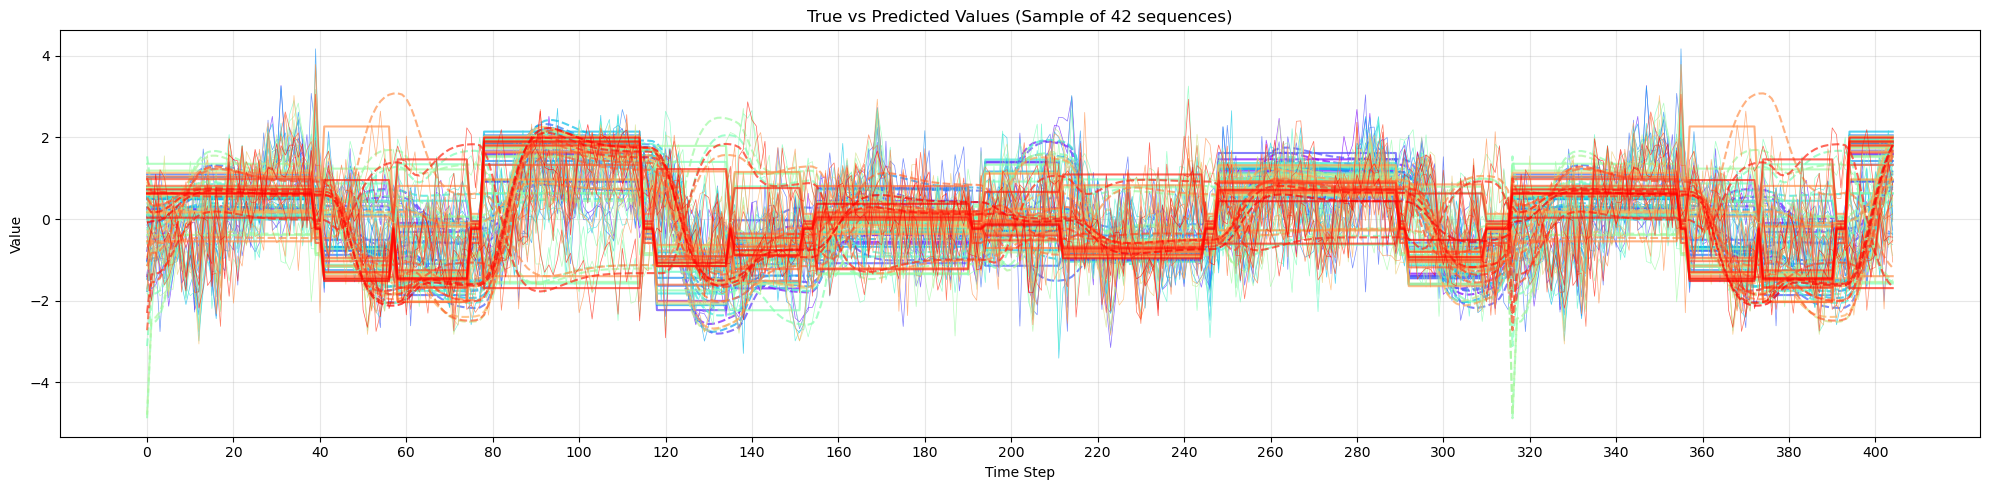

In [40]:
plot_voxels(subset_dataset.X[0, 0], subset_dataset.Y[0, 0], subset_dataset.Y_conv[0, 0], n_samples=n_samples, seed=None, print_x=True)

(1989, 405) (1989, 405) (1989, 405)


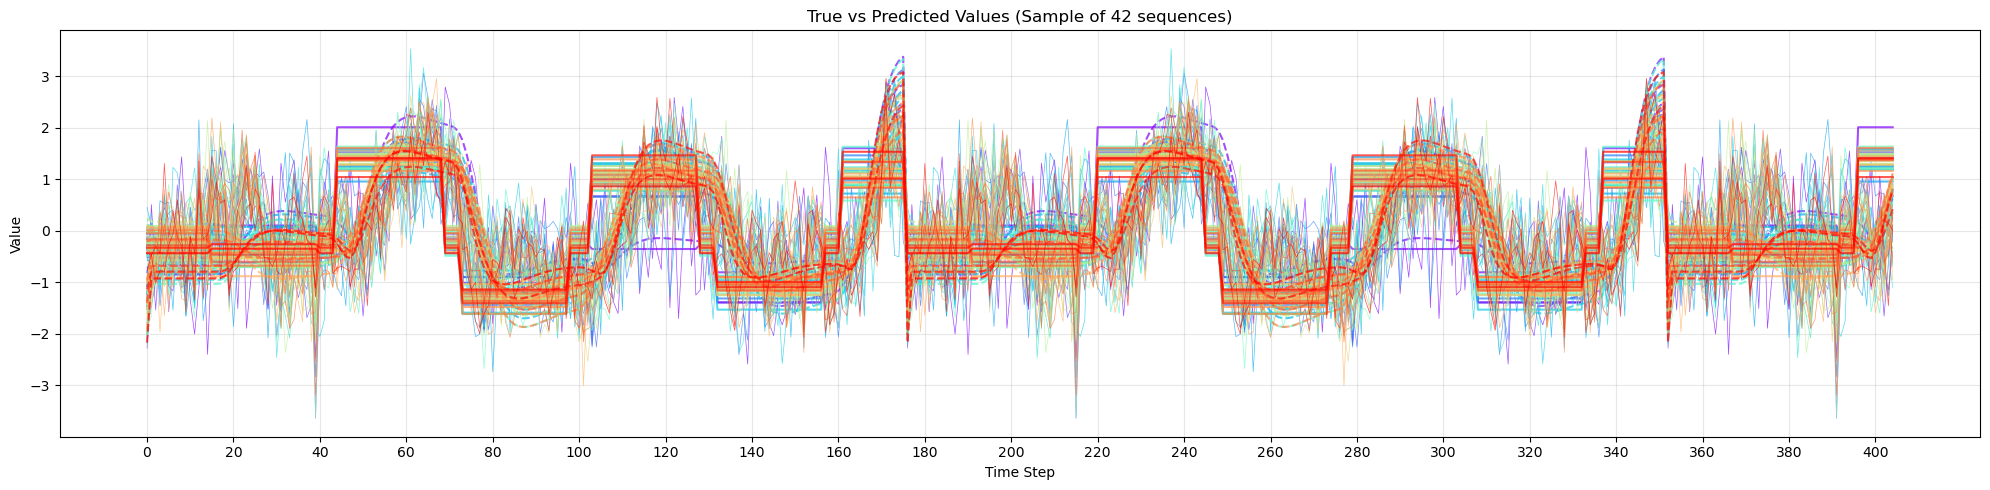

In [41]:
plot_voxels(subset_dataset.X[1, 0], subset_dataset.Y[1, 0], subset_dataset.Y_conv[1, 0], n_samples=n_samples, seed=None, print_x=True)